In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [3]:
import pandas as pd

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [20]:
bright_factor = 0.75
runs_dict = dict()
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0, "config.normtype_detach": 1,
                                                            "config.excitation_training": 1, "config.layer_norm": None, "config.feedback_alignment":0, "config.use_testset": True}, order="-summary_metrics.test_acc")

In [21]:
history_fc0 = []
history_fc1 = []

In [22]:
for run in runs_dict["runs_homeostasis"]:
    history_fc0.append(run.history(samples=500000, keys=["gradient_alignment_fc0", "output_alignment_fc0"]))
    history_fc1.append(run.history(samples=500000, keys=["gradient_alignment_fc1", "output_alignment_fc1"]))

In [23]:
# Stack the underlying numpy arrays
data_fc0 = np.stack([df.values for df in history_fc0])  # shape: (5, 3, 4)
# Compute mean
history_fc0_mean = pd.DataFrame(np.mean(data_fc0, axis=0), columns=history_fc0[0].columns)
history_fc0_std = pd.DataFrame(np.std(data_fc0, axis=0), columns=history_fc0[0].columns)

# Stack the underlying numpy arrays
data_fc1 = np.stack([df.values for df in history_fc1])  # shape: (5, 3, 4)
# Compute mean
history_fc1_mean = pd.DataFrame(np.mean(data_fc1, axis=0), columns=history_fc1[0].columns)
history_fc1_std = pd.DataFrame(np.std(data_fc1, axis=0), columns=history_fc1[0].columns)


In [24]:
print(history_fc0_mean.columns)
print(history_fc1_mean.columns)

Index(['_step', 'gradient_alignment_fc0', 'output_alignment_fc0'], dtype='object')
Index(['_step', 'gradient_alignment_fc1', 'output_alignment_fc1'], dtype='object')


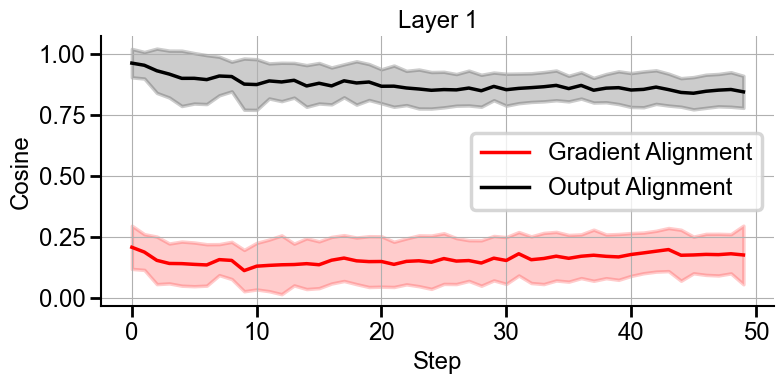

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
gradient_mu_fc0 = history_fc0_mean["gradient_alignment_fc0"]
gradient_std_fc0 = history_fc0_std["gradient_alignment_fc0"]
ax.plot(gradient_mu_fc0, label="Gradient Alignment", color='red')
ax.fill_between(range(len(gradient_mu_fc0)), gradient_mu_fc0 - gradient_std_fc0, gradient_mu_fc0 + gradient_std_fc0, alpha=0.2, color='red')
output_mu_fc0 = history_fc0_mean["output_alignment_fc0"]
output_std_fc0 = history_fc0_std["output_alignment_fc0"]
ax.plot(output_mu_fc0, label="Output Alignment", color='black')
ax.fill_between(range(len(output_mu_fc0)), output_mu_fc0 - output_std_fc0, output_mu_fc0 + output_std_fc0, alpha=0.2, color='black')
ax.set_xlabel("Step")
ax.set_ylabel("Cosine")
ax.set_title("Layer 1")
ax.legend()
ax.grid(True)

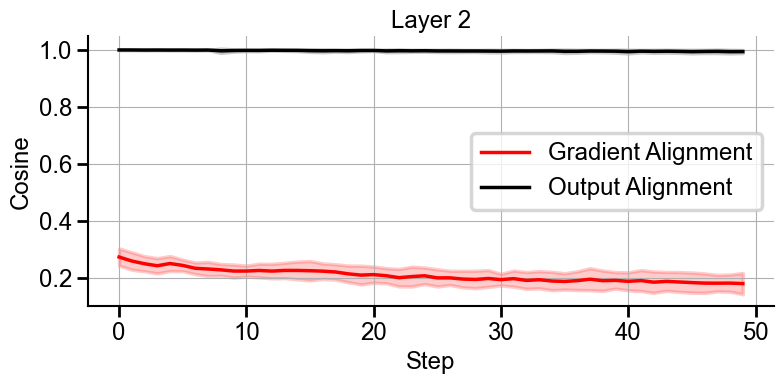

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
gradient_mu_fc1 = history_fc1_mean["gradient_alignment_fc1"]
gradient_std_fc1 = history_fc1_std["gradient_alignment_fc1"]
ax.plot(gradient_mu_fc1, label="Gradient Alignment", color='red')
ax.fill_between(range(len(gradient_mu_fc1)), gradient_mu_fc1 - gradient_std_fc1, gradient_mu_fc1 + gradient_std_fc1, alpha=0.2, color='red')
output_mu_fc1 = history_fc1_mean["output_alignment_fc1"]
output_std_fc1 = history_fc1_std["output_alignment_fc1"]
ax.plot(output_mu_fc1, label="Output Alignment", color='black')
ax.fill_between(range(len(output_mu_fc1)), output_mu_fc1 - output_std_fc1, output_mu_fc1 + output_std_fc1, alpha=0.2, color='black')
ax.set_xlabel("Step")
ax.set_ylabel("Cosine")
ax.set_title("Layer 2")
ax.legend()
ax.grid(True)

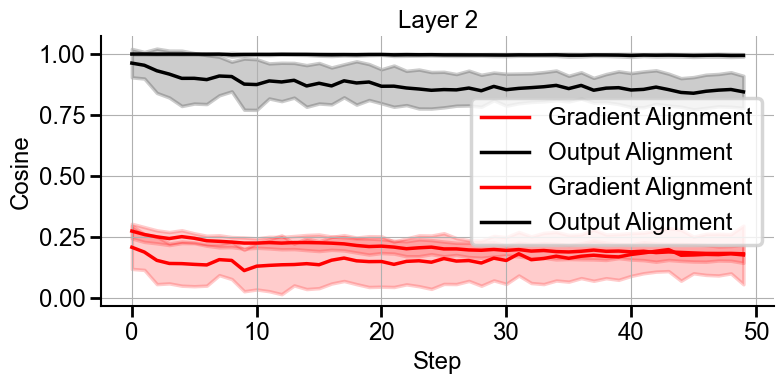

In [30]:
fig, ax = plt.subplots(figsize=(8, 4))
for lyr in ['fc0', 'fc1']:
    gradient_mu_fc1 = globals()[f'history_{lyr}_mean'][f'gradient_alignment_{lyr}']
    gradient_std_fc1 = globals()[f'history_{lyr}_std'][f'gradient_alignment_{lyr}']
    ax.plot(gradient_mu_fc1, label="Gradient Alignment", color='red')
    ax.fill_between(range(len(gradient_mu_fc1)), gradient_mu_fc1 - gradient_std_fc1, gradient_mu_fc1 + gradient_std_fc1, alpha=0.2, color='red')
    output_mu_fc1 = globals()[f'history_{lyr}_mean'][f'output_alignment_{lyr}']
    output_std_fc1 = globals()[f'history_{lyr}_std'][f'output_alignment_{lyr}']
    ax.plot(output_mu_fc1, label="Output Alignment", color='black')
    ax.fill_between(range(len(output_mu_fc1)), output_mu_fc1 - output_std_fc1, output_mu_fc1 + output_std_fc1, alpha=0.2, color='black')
ax.set_xlabel("Step")
ax.set_ylabel("Cosine")
# ax.set_title("Layer 2")
ax.legend()
ax.grid(True)

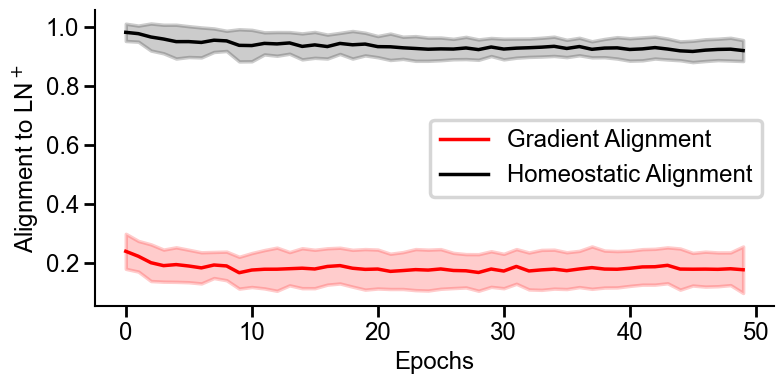

In [49]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

layers = ['fc0', 'fc1']

# Collect all means and stds for gradient and output alignment
gradient_mus = []
gradient_stds = []
output_mus = []
output_stds = []

for lyr in layers:
    gradient_mus.append(globals()[f'history_{lyr}_mean'][f'gradient_alignment_{lyr}'])
    gradient_stds.append(globals()[f'history_{lyr}_std'][f'gradient_alignment_{lyr}'])
    output_mus.append(globals()[f'history_{lyr}_mean'][f'output_alignment_{lyr}'])
    output_stds.append(globals()[f'history_{lyr}_std'][f'output_alignment_{lyr}'])

# Convert lists to arrays for easy averaging
gradient_mus = np.array(gradient_mus)
gradient_stds = np.array(gradient_stds)
output_mus = np.array(output_mus)
output_stds = np.array(output_stds)

# Compute averages across layers (axis=0)
avg_gradient_mu = np.mean(gradient_mus, axis=0)
avg_gradient_std = np.mean(gradient_stds, axis=0)
avg_output_mu = np.mean(output_mus, axis=0)
avg_output_std = np.mean(output_stds, axis=0)

steps = range(len(avg_gradient_mu))

ax.plot(steps, avg_gradient_mu, label="Gradient Alignment", color='red')
ax.fill_between(steps, avg_gradient_mu - avg_gradient_std, avg_gradient_mu + avg_gradient_std, 
                alpha=0.2, color='red')

ax.plot(steps, avg_output_mu, label="Homeostatic Alignment", color='black')
ax.fill_between(steps, avg_output_mu - avg_output_std, avg_output_mu + avg_output_std, 
                alpha=0.2, color='black')

ax.set_xlabel("Epochs")
ax.set_ylabel("Alignment to LN$^+$")
ax.legend()
# ax.grid(True)
plt.savefig("figure3a.svg", format="svg")
